https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
from theano import tensor as tt

import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data generation

In [2]:
M, N, alpha0, sigma0, sig_prob0 = 200, 100, 3., 1., .05
X = np.random.randn(N, M)
beta0 = np.random.randn(M, 1)*.25
index = np.random.binomial(1, sig_prob0, M)
beta0[index == 1, :] = np.random.randn(
    sum(index), 1) + 10*np.random.choice([-1, 1], sum(index))[:, None]
y = np.random.normal(np.dot(X, beta0)+alpha0, sigma0)

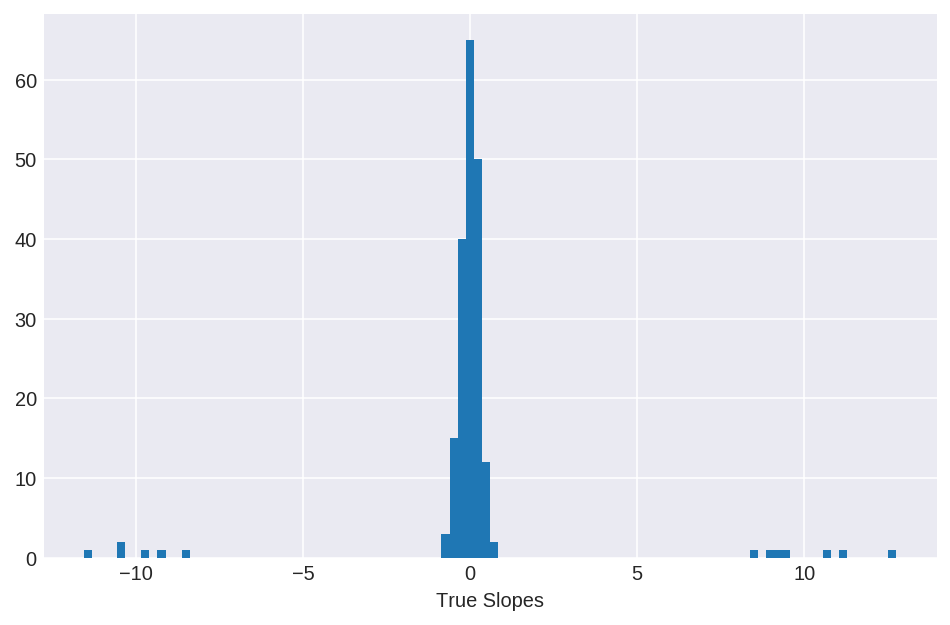

In [3]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(beta0, 100)
ax.set_xlabel('True Slopes');

## plotting

In [4]:
def plot_slope(trace, priorname):
    beta_post = np.squeeze(trace[750:]['beta']).T
    
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(np.arange(M), beta_post, alpha=.01, color='grey', linestyle='-')
    ax.step(np.arange(M), beta_post.mean(axis=1), color='r')
    ax.step(beta0, 'k', alpha=.5)
    ax.vlines(np.where(index==1)[0]-.5,
              -15, 15, linestyle='--', alpha=.5)
    ax.set_title(priorname)
    ax.set_xlabel('Slope Index')
    ax.set_ylabel('Slope Posterior')
    return ax

In [5]:
def plot_slope_diff(trace, priorname):
    beta_post = np.squeeze(trace[750:]['beta']).T
    
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(np.arange(M), beta_post-beta0, alpha=.01, color='grey', linestyle='-')
    ax.step(np.arange(M), beta_post.mean(axis=1, keepdims=True)-beta0, color='r')
    ax.hlines(0, 0, M, 'k', alpha=.5)
    ax.vlines(np.where(index==1)[0]-.5,
              -15, 15, linestyle='--', alpha=.5)
    ax.set_title(priorname)
    ax.set_xlabel('Slope Index')
    ax.set_ylabel('Slope Posterior')
    return ax

In [6]:
def plot_posterior(trace, priorname):
    axes = pm.plot_posterior(trace, 
                      varnames=['alpha', 'sigma'], 
                      ref_val=[alpha0, sigma0],
                      color='#87ceeb');
    axes[0].set_title('priorname')
    axes[0].set_xlabel('alpha')
    axes[1].set_title('priorname')
    axes[1].set_xlabel('sigma')
    return axes

## Uniform Prior

In [7]:
with pm.Model() as unif:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Flat('beta', shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace0 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma_log__, alpha]
  9%|▉         | 179/2000 [00:09<01:34, 19.18it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '16651' (I am process '16652')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16651' (I am process '16653')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
 11%|█         | 216/2000 [00:17<02:28, 12.01it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '16652' (I am process '16653')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux

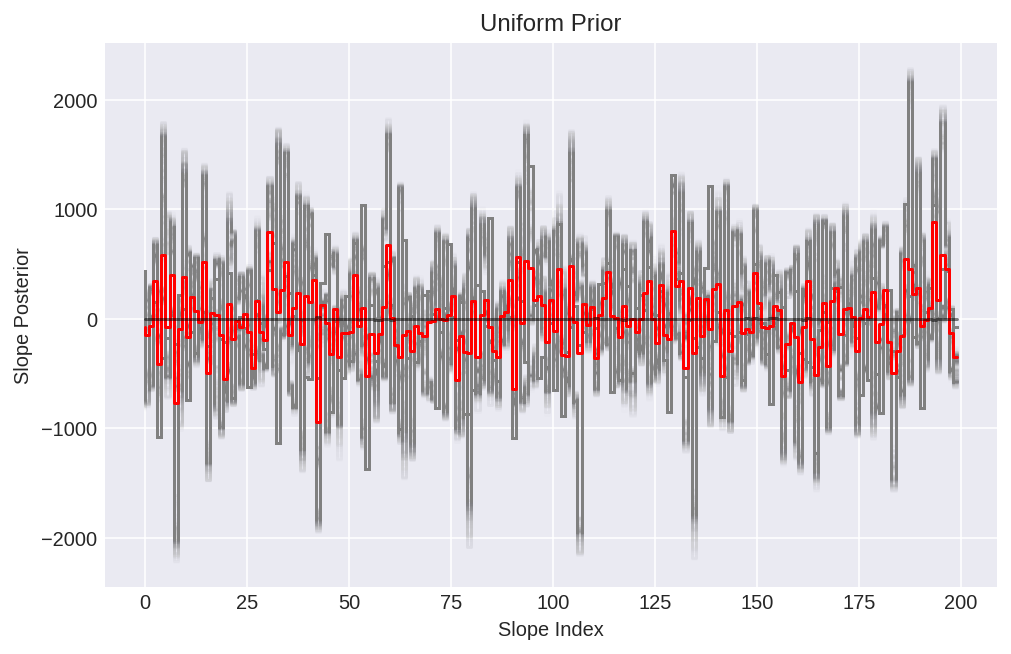

In [8]:
plot_slope(trace0, 'Uniform Prior');

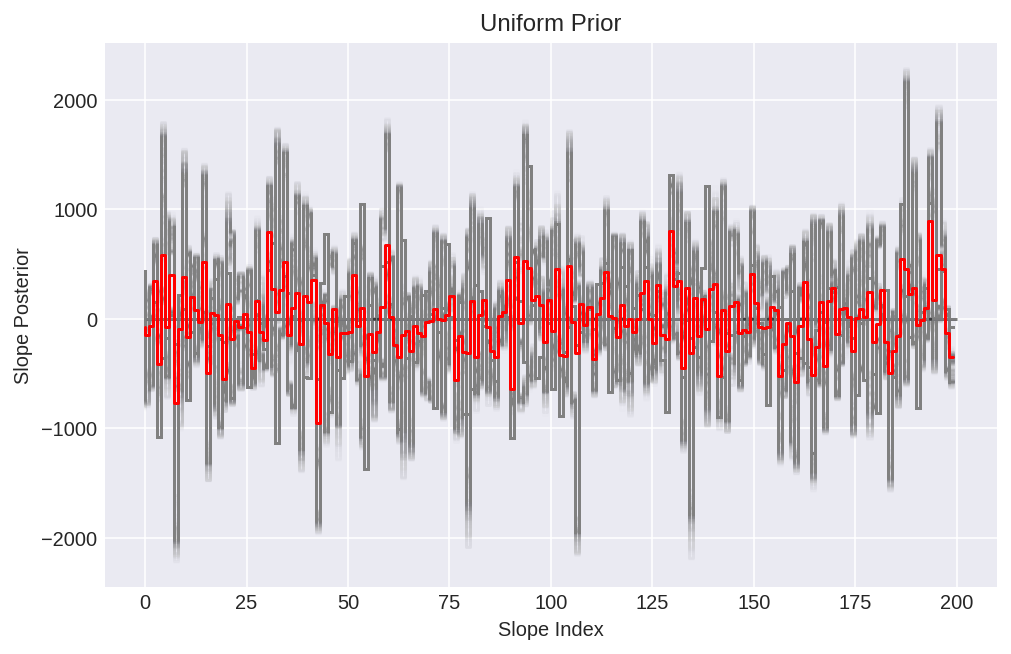

In [9]:
plot_slope_diff(trace0, 'Uniform Prior');

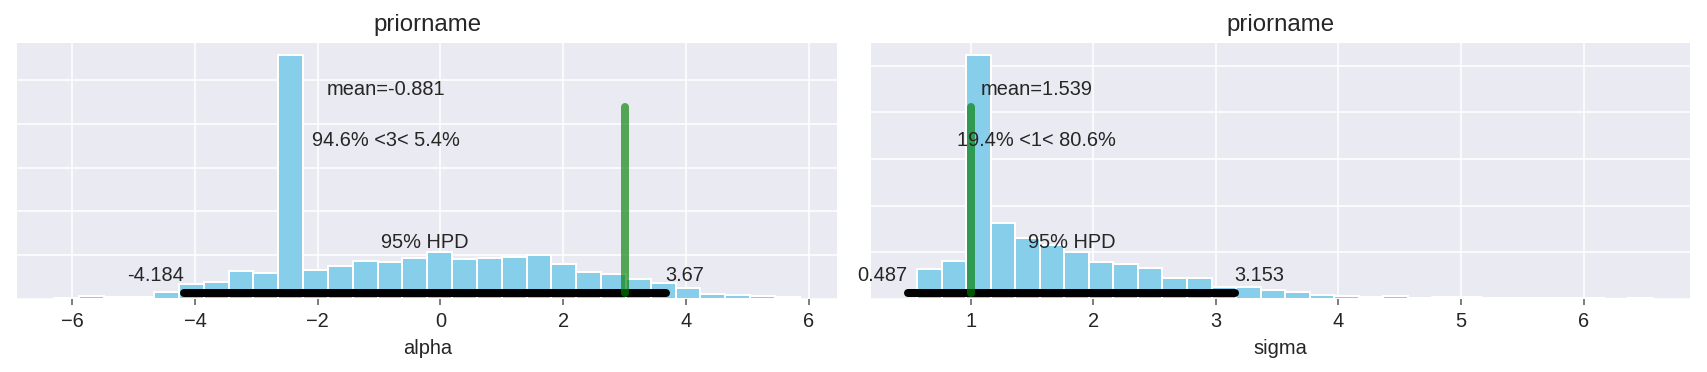

In [10]:
plot_posterior(trace0, 'Uniform Prior');

## Wide Weakly Informative Prior

In [11]:
with pm.Model() as wide:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Normal('beta', mu=0., sd=10., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace1 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma_log__, alpha]
100%|██████████| 2000/2000 [21:42<00:00,  1.54it/s]
The acceptance probability does not match the target. It is 0.982456943817743, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7161862634472699, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


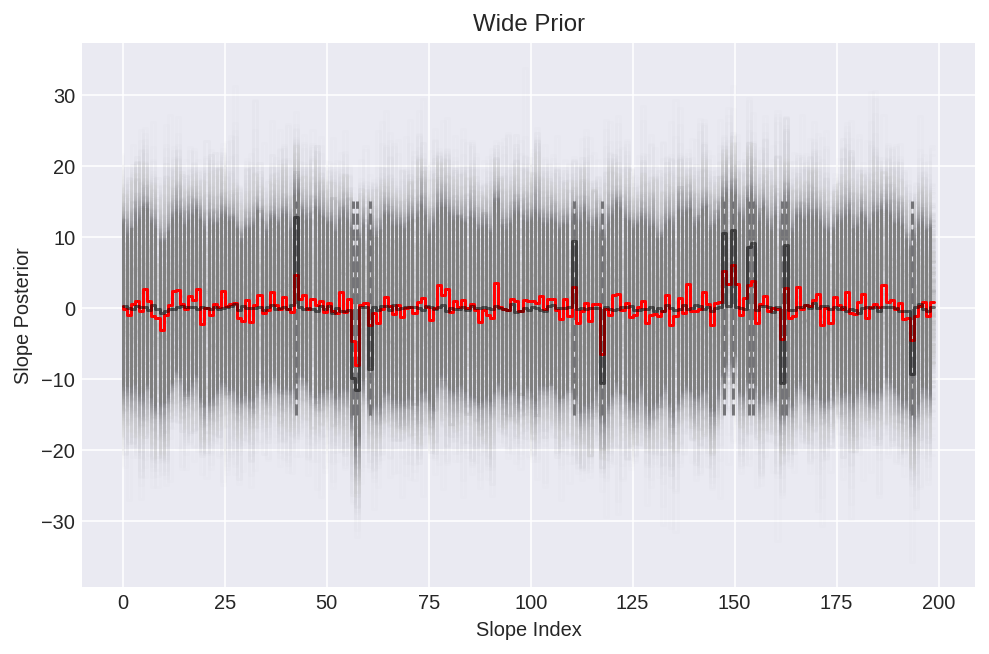

In [12]:
plot_slope(trace1, 'Wide Prior');

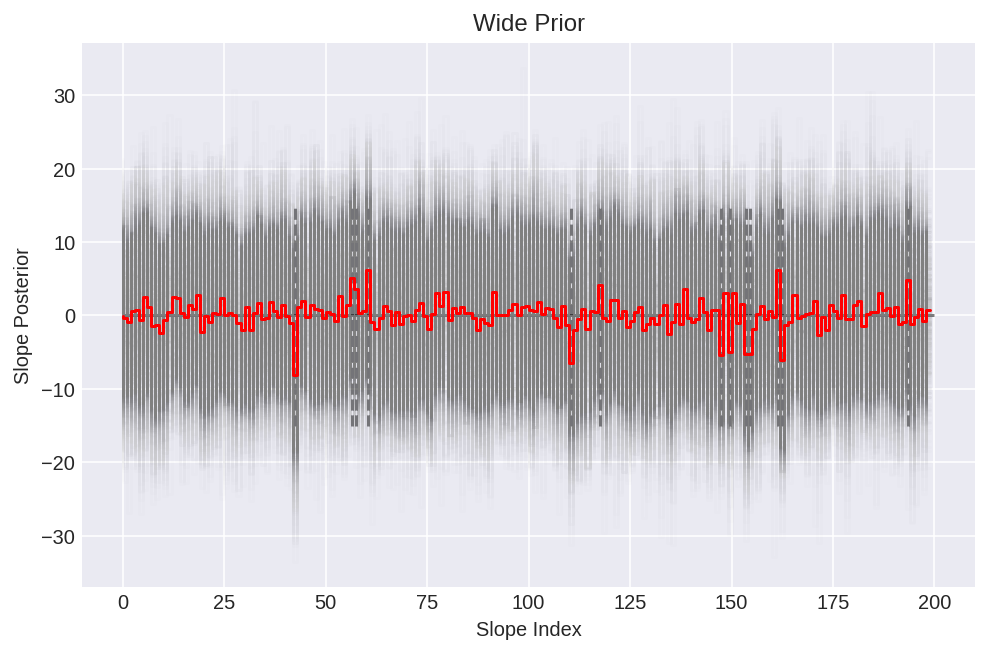

In [13]:
plot_slope_diff(trace1, 'Wide Prior');

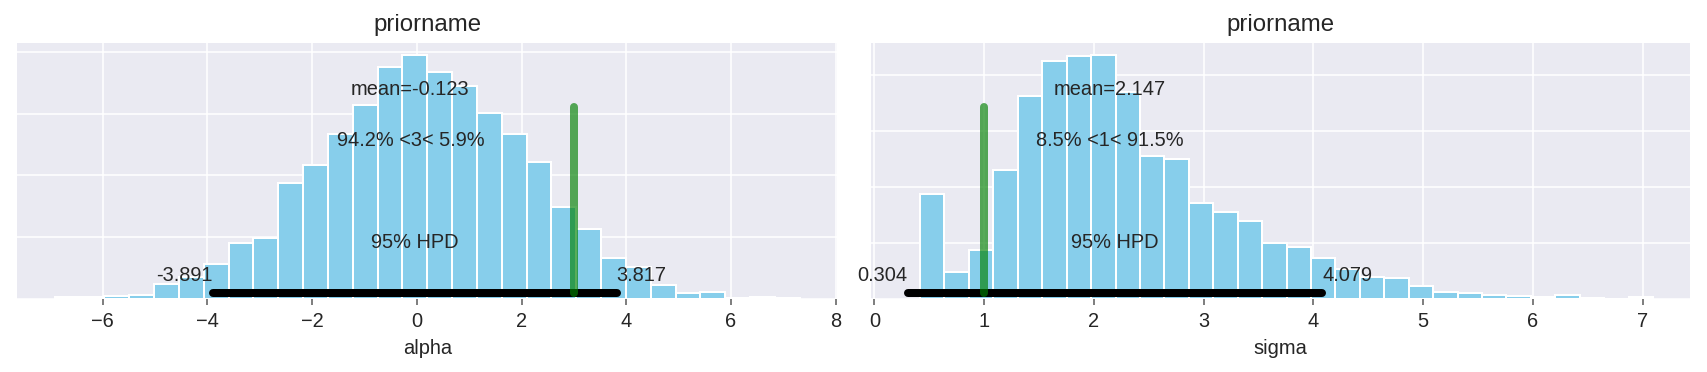

In [14]:
plot_posterior(trace1, 'Wide Prior');

## Narrow Weakly Informative Prior

In [15]:
with pm.Model() as narrow:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Normal('beta', mu=0., sd=1., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace2 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma_log__, alpha]
100%|██████████| 2000/2000 [00:40<00:00, 49.11it/s]


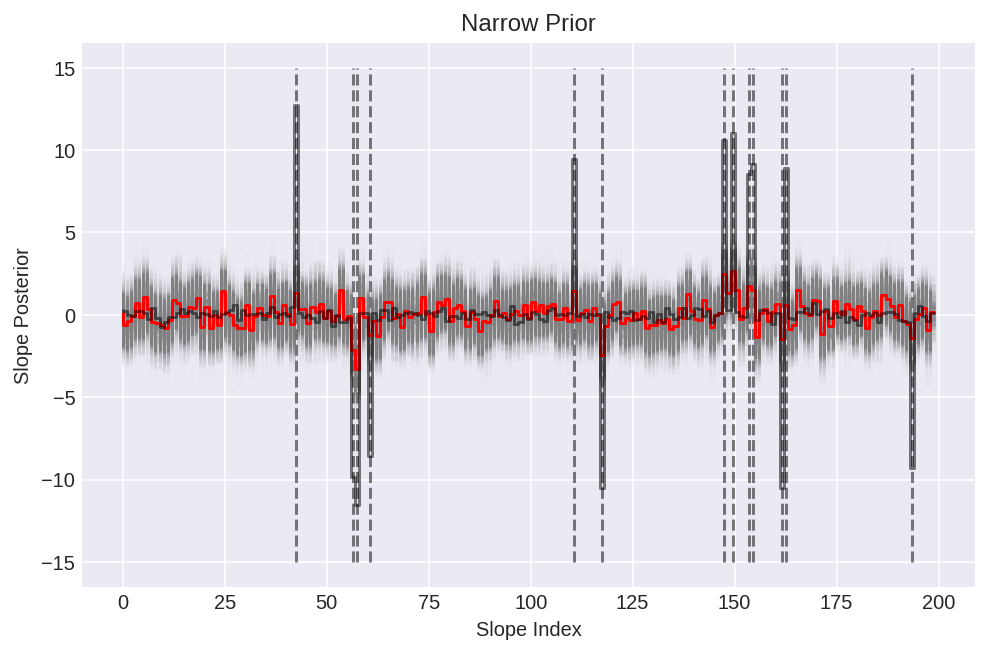

In [16]:
plot_slope(trace2, 'Narrow Prior');

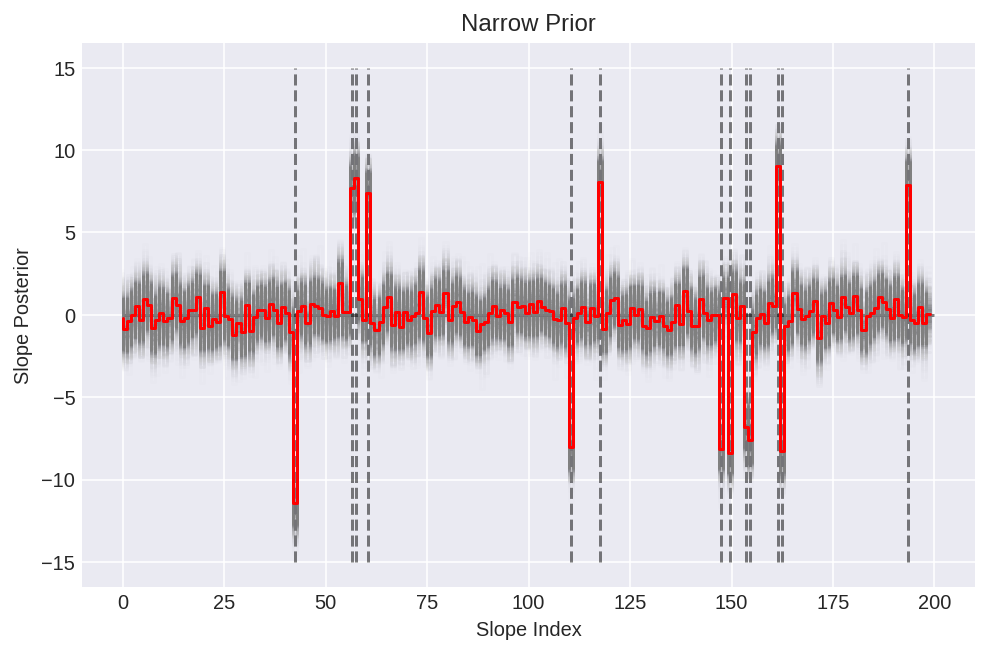

In [17]:
plot_slope_diff(trace2, 'Narrow Prior');

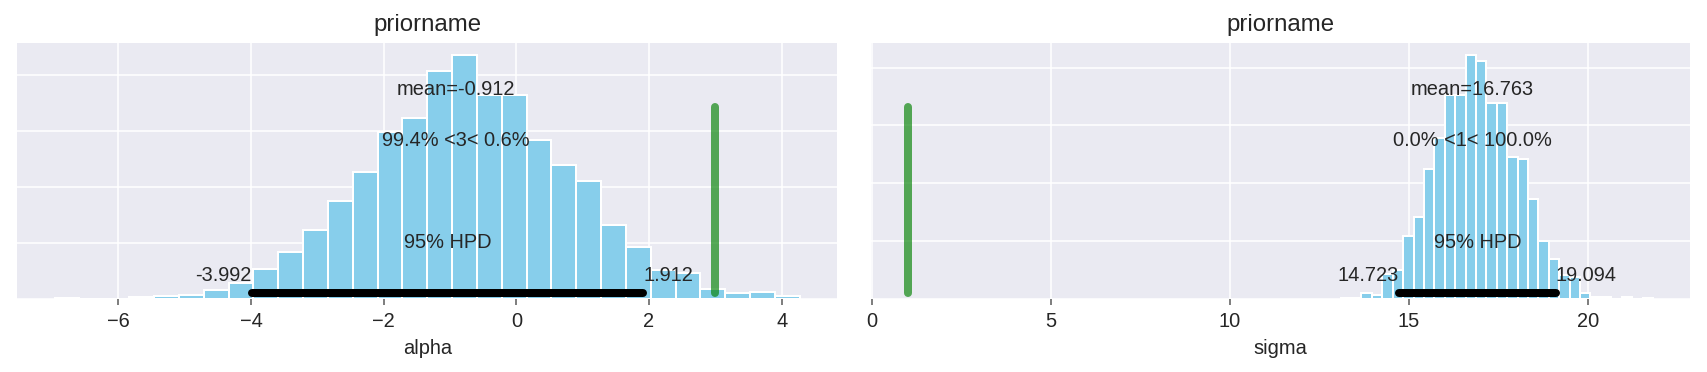

In [18]:
plot_posterior(trace2, 'Narrow Prior');

## Laplace Prior

In [19]:
with pm.Model() as laplace:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Laplace('beta', mu=0., b=1., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace3 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma_log__, alpha]
100%|██████████| 2000/2000 [09:14<00:00,  3.61it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.53783516461172, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


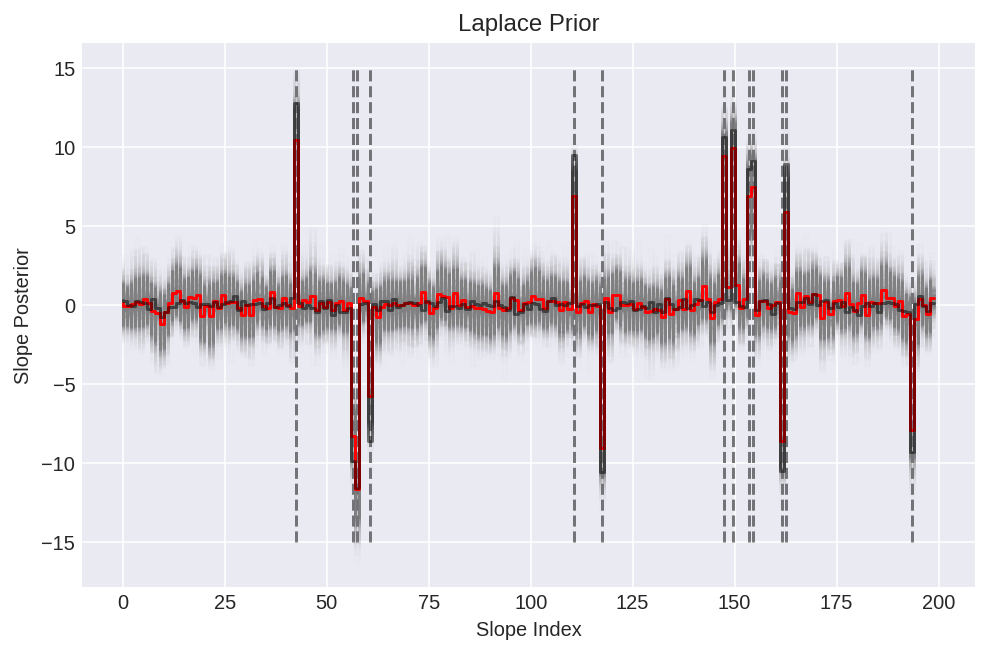

In [20]:
plot_slope(trace3, 'Laplace Prior');

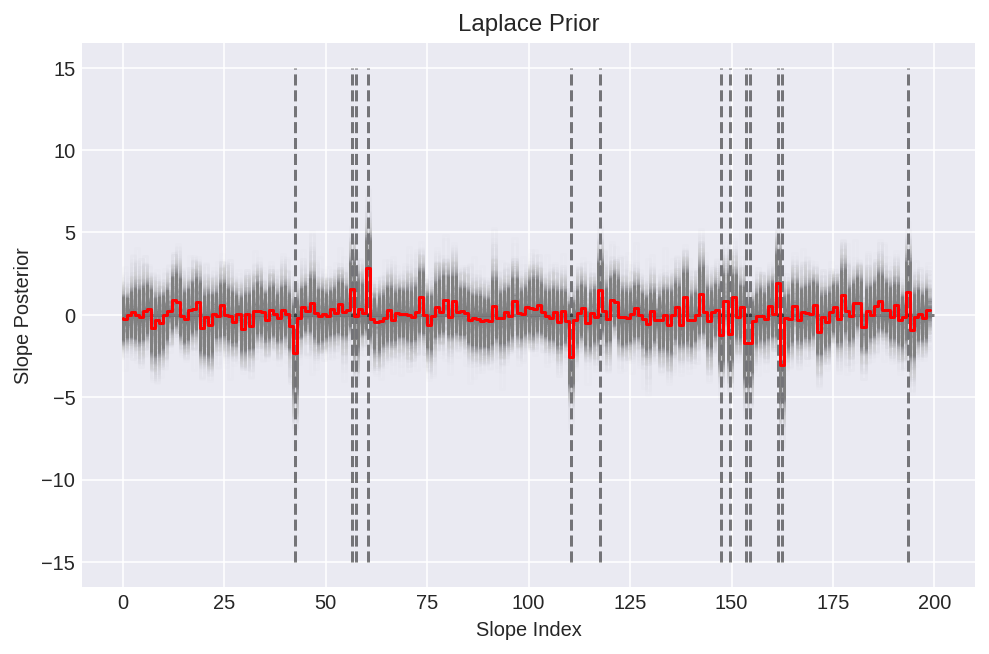

In [21]:
plot_slope_diff(trace3, 'Laplace Prior');

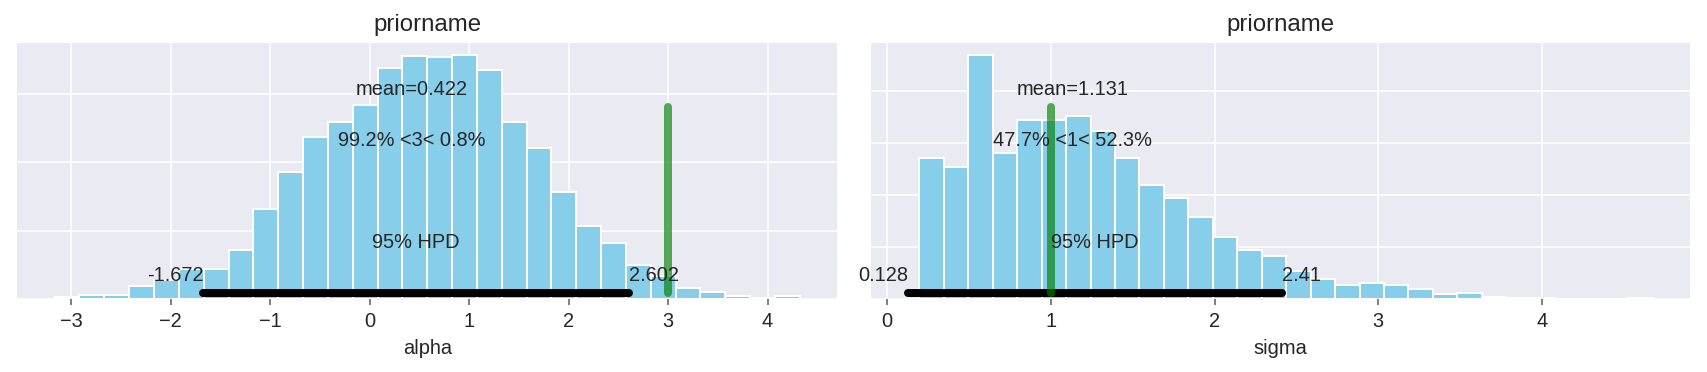

In [22]:
plot_posterior(trace3, 'Laplace Prior');

## The Horseshoe

In [23]:
with pm.Model() as horseshoe:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)

    beta_tilde = pm.Normal('beta_tilde', mu=0., sd=1., shape=(M, 1))
    lambda_ = pm.HalfCauchy('lambda', beta=1., shape=(M, 1))
    tau_tilde = pm.HalfCauchy('tau_tilde', beta=1.)
    beta = pm.Deterministic('beta', beta_tilde * lambda_ * sigma * tau_tilde)
    
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace4 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_tilde_log__, lambda_log__, beta_tilde, sigma_log__, alpha]
100%|██████████| 2000/2000 [15:15<00:00,  2.19it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.07423417378527318, but should be close to 0.8. Try to increase the number of tuning steps.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7110716188264022, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.10490917611861557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 220 divergences after tuning. Increase `target_

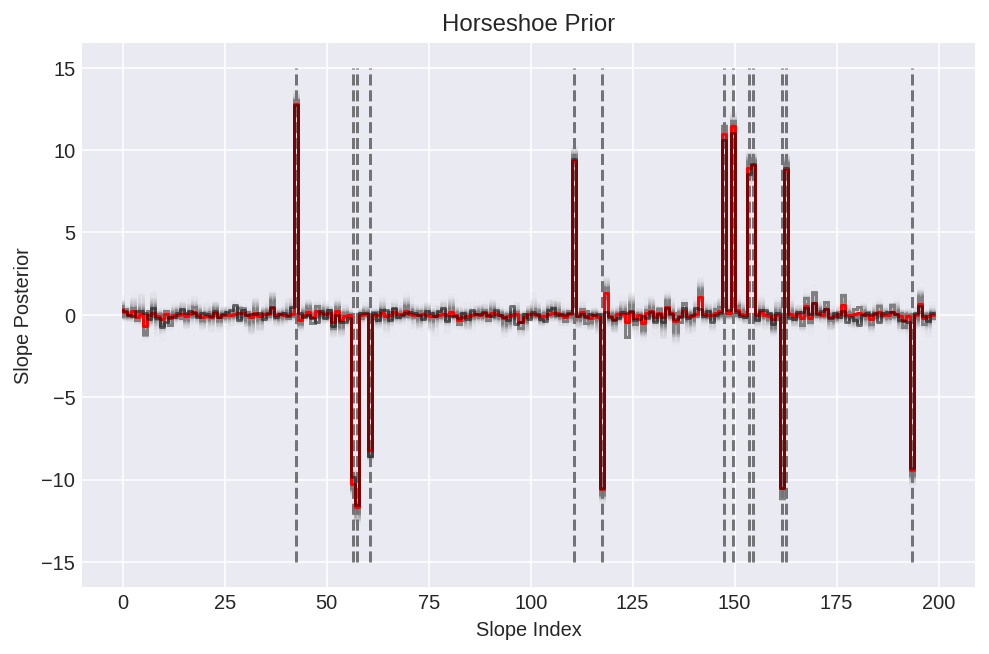

In [24]:
plot_slope(trace4, 'Horseshoe Prior');

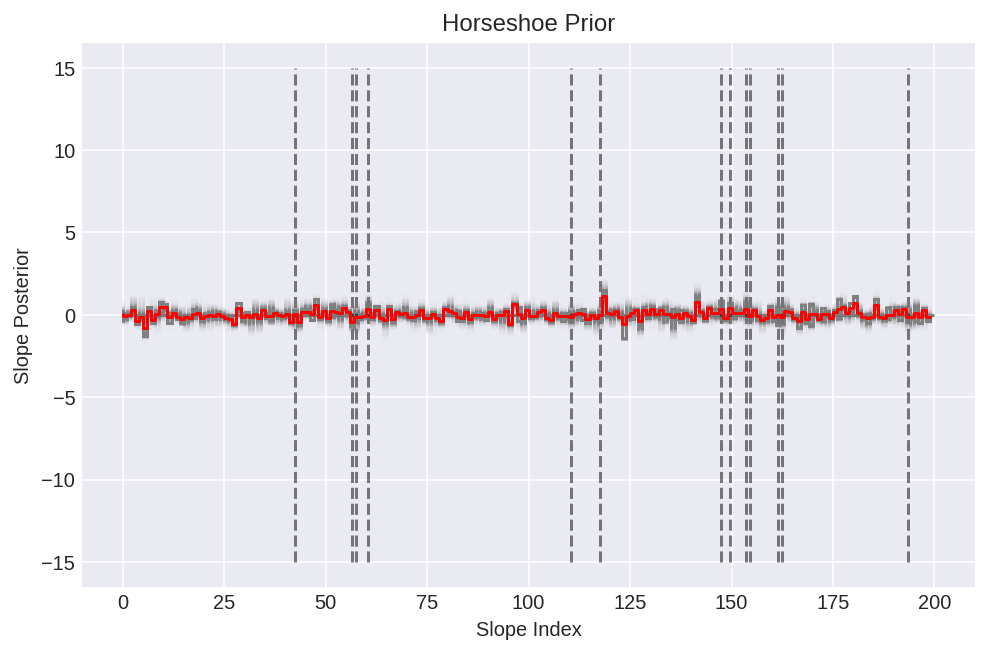

In [25]:
plot_slope_diff(trace4, 'Horseshoe Prior');

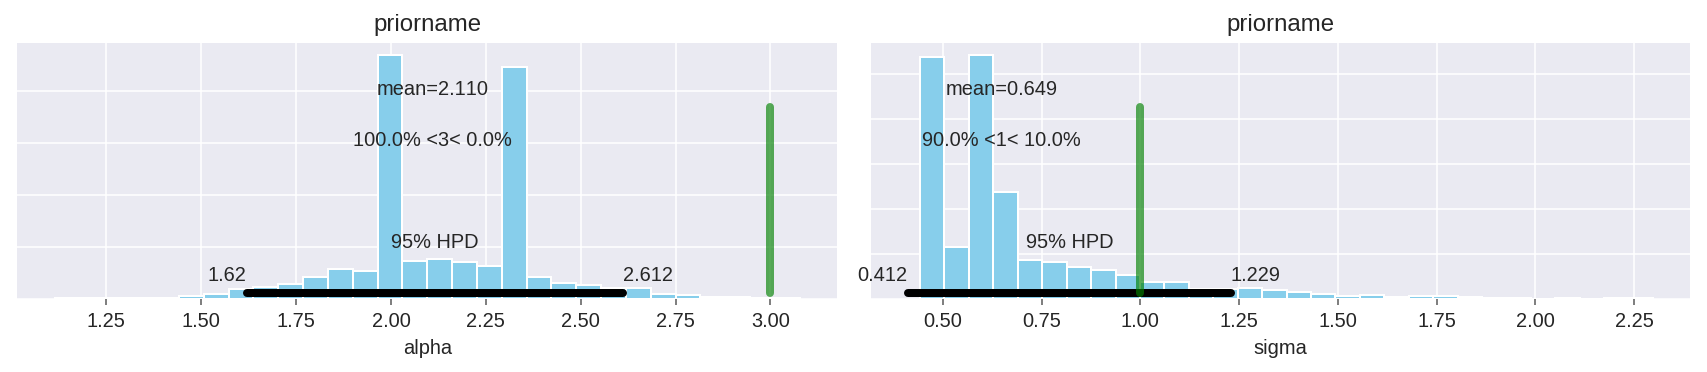

In [26]:
plot_posterior(trace4, 'Horseshoe Prior');

## The Finnish Horseshoe

In [27]:
m0 = 10            # Expected number of large slopes
slab_scale = 3,    # Scale for large slopes
slab_scale2 = np.square(slab_scale)
slab_df = 25.      # Effective degrees of freedom for large slopes
half_slab_df = 0.5 * slab_df

In [28]:
with pm.Model() as finnish_horseshoe:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)

    beta_tilde = pm.Normal('beta_tilde', mu=0., sd=1., shape=(M, 1))
    lambda_ = pm.HalfCauchy('lambda', beta=1., shape=(M, 1))
    tau_tilde = pm.HalfCauchy('tau_tilde', beta=1.)
    c2_tilde = pm.InverseGamma(
        'c2_tilde', alpha=half_slab_df, beta=half_slab_df)

    tau0 = (m0 / (M - m0)) * (sigma / np.sqrt(1.0 * N))
    tau = tau0 * tau_tilde  # tau ~ cauchy(0, tau0)
    # c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
    # Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
    c2 = slab_scale2 * c2_tilde

    lambda_tilde = tt.sqrt(c2 * tt.square(lambda_) /
                           (c2 + tt.square(tau) * tt.square(lambda_)))
    # beta ~ normal(0, tau * lambda_tilde)
    beta = pm.Deterministic('beta', tau * lambda_tilde * beta_tilde)

    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace5 = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2_tilde_log__, tau_tilde_log__, lambda_log__, beta_tilde, sigma_log__, alpha]
100%|██████████| 2000/2000 [18:08<00:00,  1.84it/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7185325689491476, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


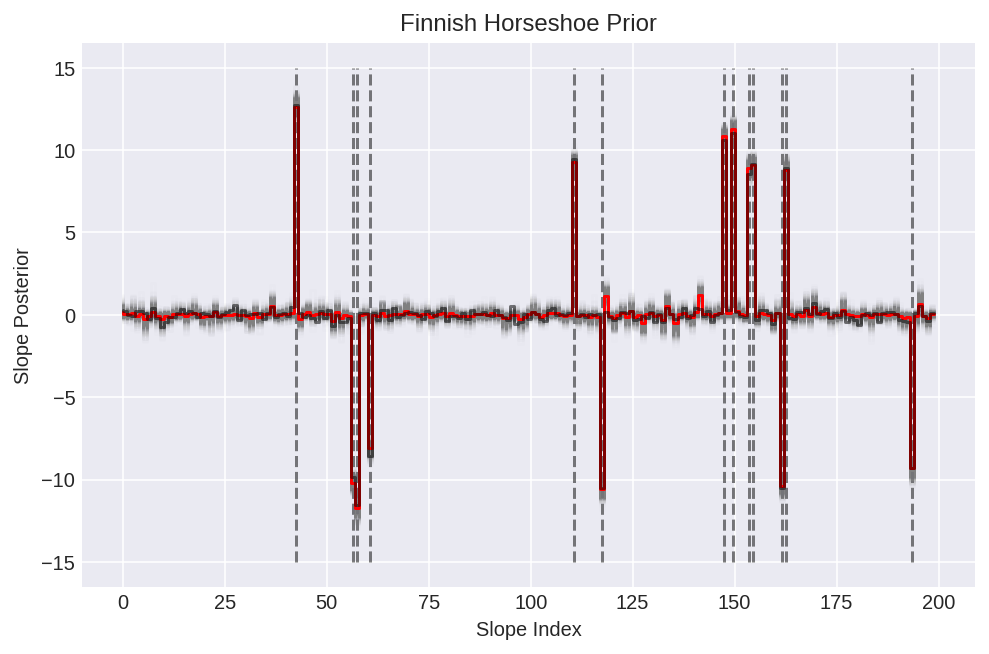

In [29]:
plot_slope(trace5, 'Finnish Horseshoe Prior');

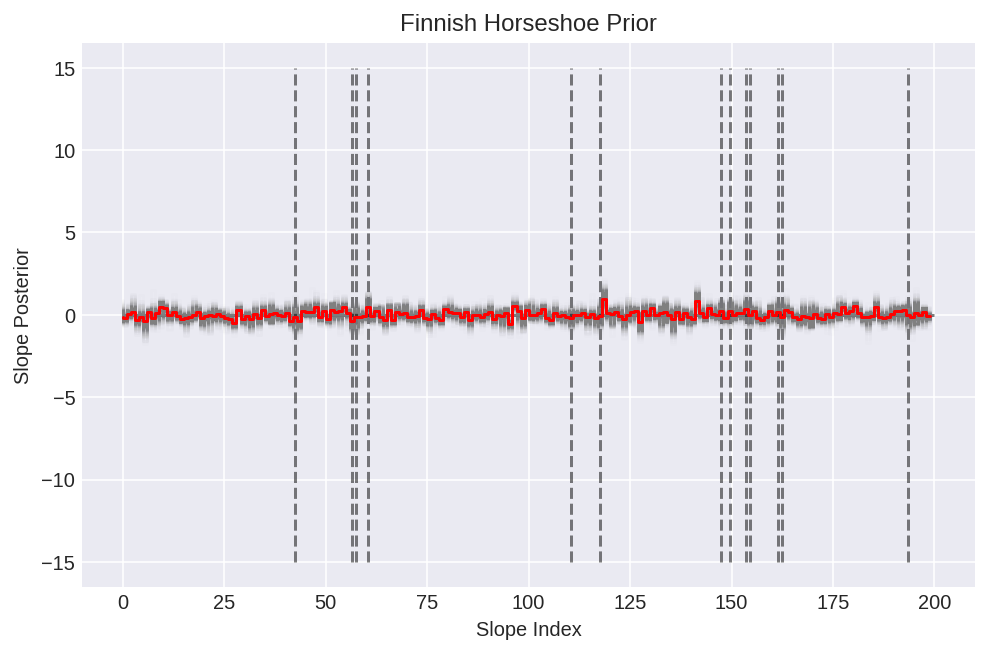

In [30]:
plot_slope_diff(trace5, 'Finnish Horseshoe Prior');

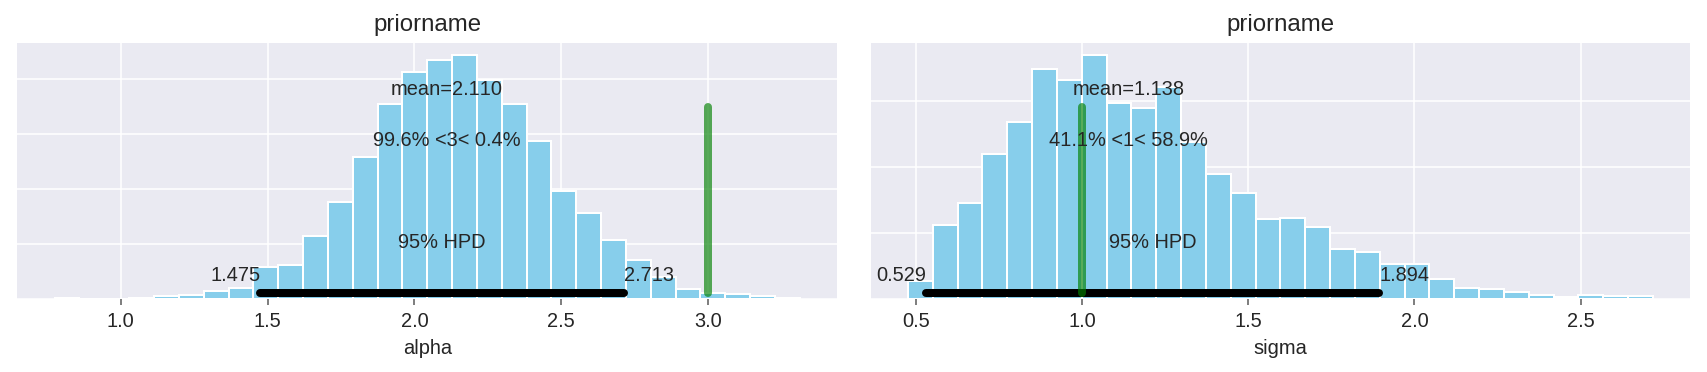

In [31]:
plot_posterior(trace5, 'Finnish Horseshoe Prior');

## Comparison

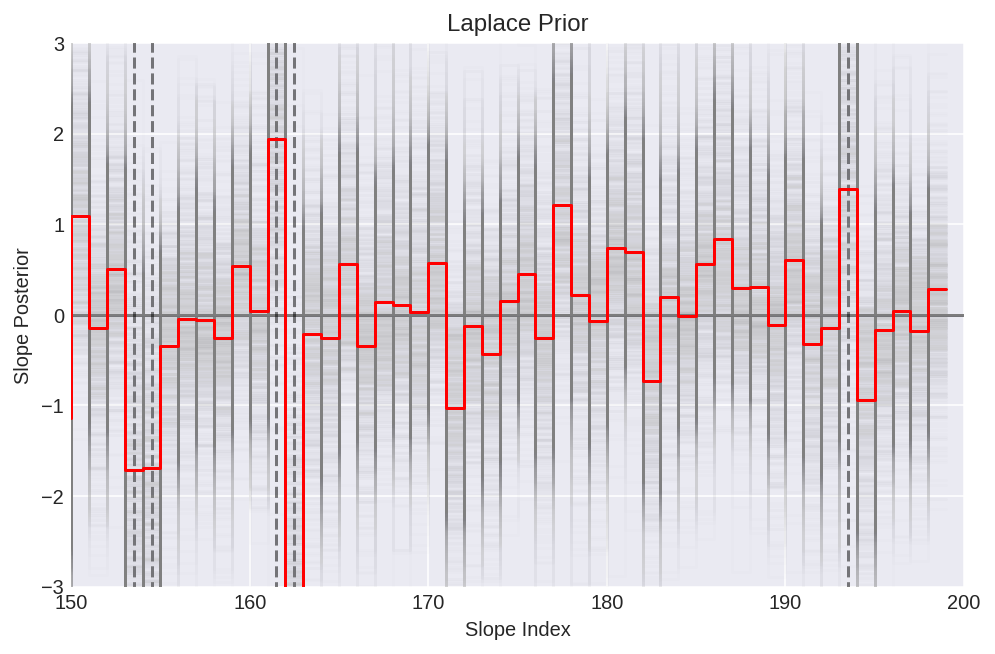

In [32]:
ax = plot_slope_diff(trace3, 'Laplace Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);

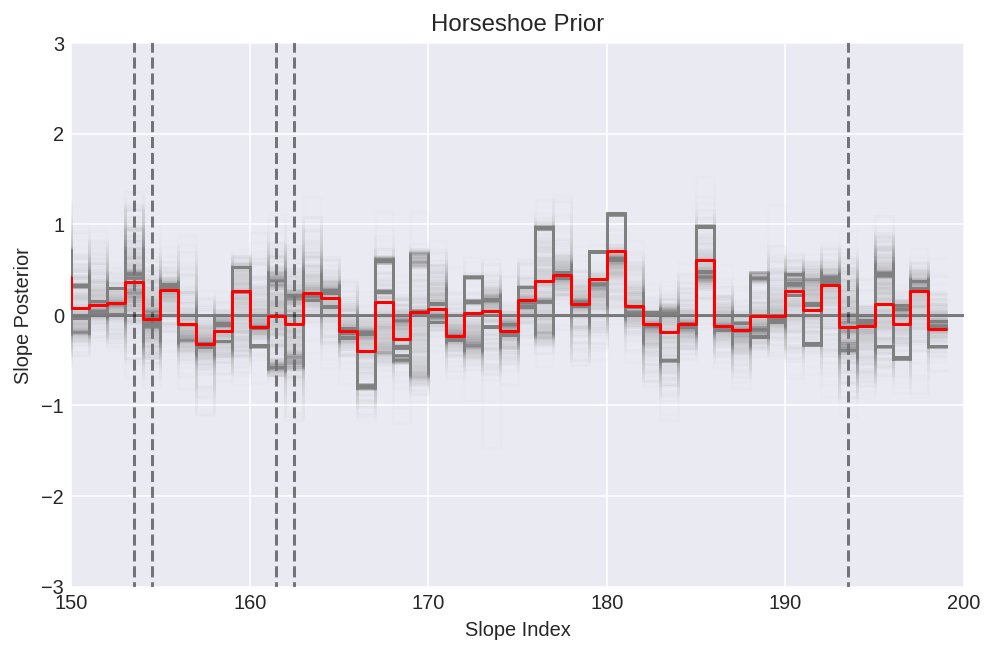

In [33]:
ax = plot_slope_diff(trace4, 'Horseshoe Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);

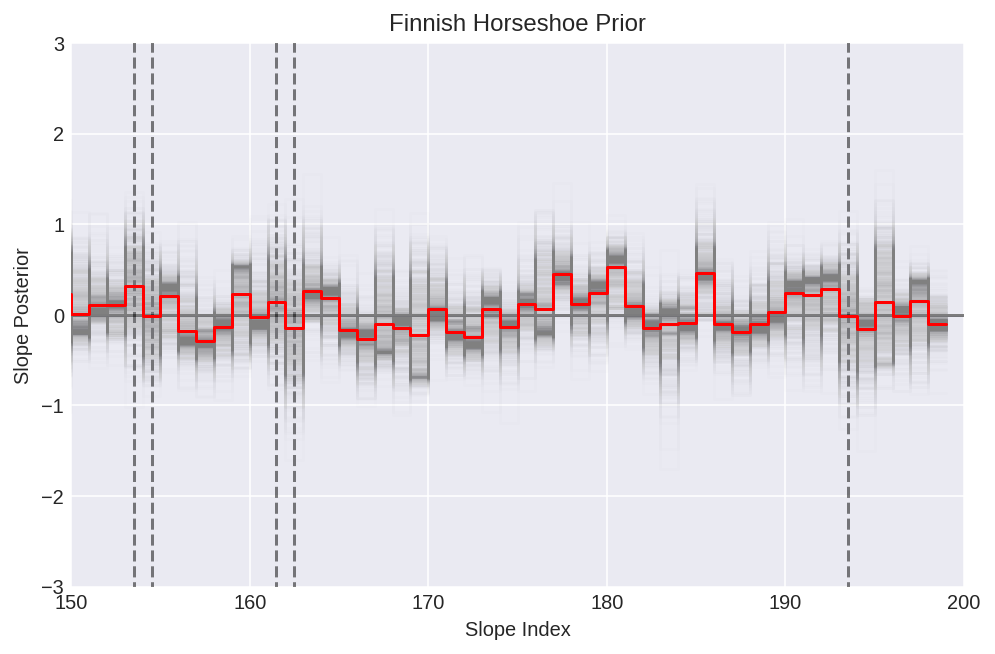

In [34]:
ax = plot_slope_diff(trace5, 'Finnish Horseshoe Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);